In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
import torch, torcwa
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt

from utils.paths import *
from utils import utils
from evaluation.diffraction_measurement import torcwa_simulation
from data.data_config import get_data_cfg
from evaluation.metrics import *

# Load a Clean Sample (Beam Splitter - Section 3.2)

In [2]:
# Load the meta-atom
data_cfg = get_data_cfg('c2')
sample = torch.load(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'uniform-beam-splitter.pt'), weights_only=False)['0']
idx = 29 # the sample presented in the paper, section 3.2
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


layer = utils.binary_projection(sample['sample'][-1][idx][0], beta=1e6).to(device)
h = sample['sample'][-1][idx][1].mean().to(device) * max(data_cfg.heights)
lam = sample['lvec'][idx].to(device)
desired_scatterings = utils.reconstruct_scatterings(sample['desired_scatterings'][idx:idx+1], data_cfg)
phy_kwargs = dict(periodicity=data_cfg.periodicity, h=h, lam=lam, tet=0.0, substrate=data_cfg.substrate, structure=data_cfg.structure)

# Height Error Test

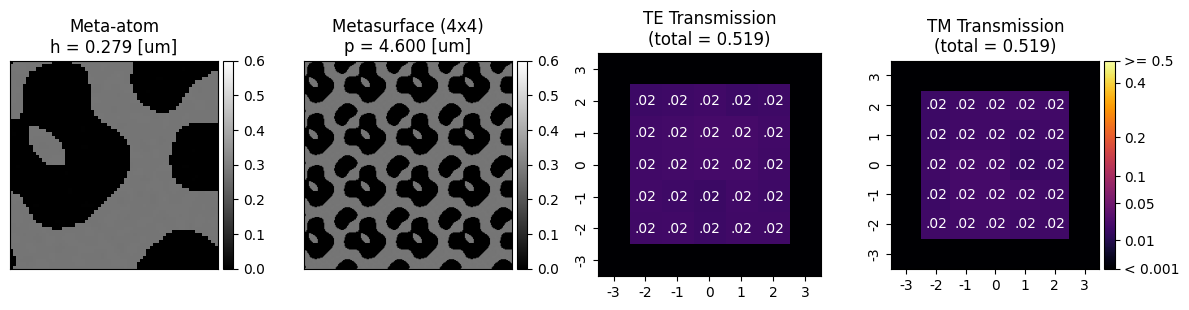

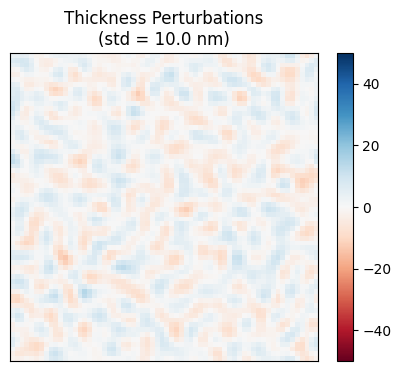

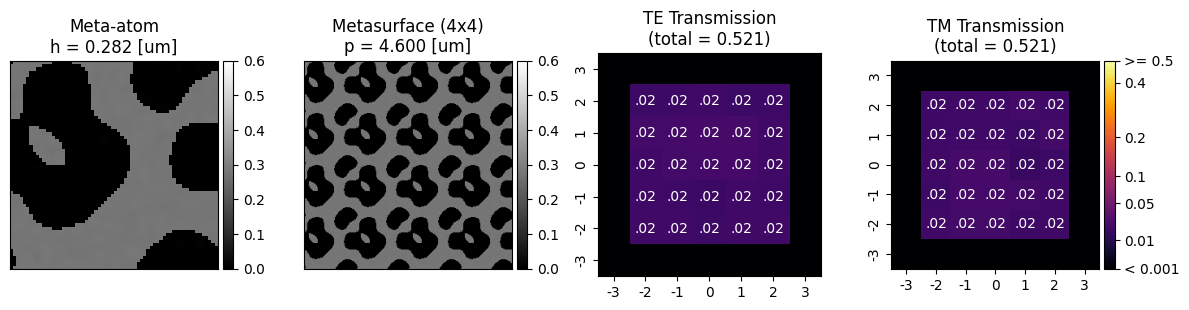

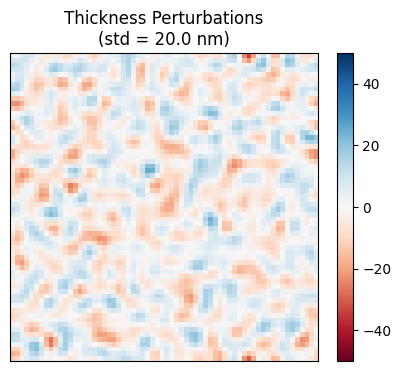

In [43]:


stds = torch.linspace(0, 0.02, 21)

te_relative_errors = []
tm_relative_errors = []
te_ue_errors = []
tm_ue_errors = []

for std in stds:
    noise_sample = torch.randn_like(layer)
    noise_sample = utils.smoothing(noise_sample, type='smooth_rect', p=data_cfg.periodicity, min_feature_size=0.3)
    noise = std * noise_sample
    noised_layer = (layer + noise).clamp_min(0)
    phy_kwargs = dict(periodicity=data_cfg.periodicity, h=h, lam=lam, tet=0.0, substrate=data_cfg.substrate, structure=data_cfg.structure)
    scatterings = torcwa_simulation(phy_kwargs, noised_layer, project=False, rcwa_orders=data_cfg.rcwa_orders)
    # utils.show_meta_atom_and_scatterings(meta_atom=h*noised_layer, s1=scatterings['Tte'], s2=scatterings['Ttm'], type='te-tm', data_cfg=data_cfg)
    te_relative_errors.append(relative_error(scatterings['Tte'], desired_scatterings['Tte'][0]).item())
    tm_relative_errors.append(relative_error(scatterings['Ttm'], desired_scatterings['Ttm'][0]).item())
    te_ue_errors.append(uniformity_error(scatterings['Tte'], desired_scatterings['Tte'][0]).item())
    tm_ue_errors.append(uniformity_error(scatterings['Ttm'], desired_scatterings['Ttm'][0]).item())

    if torch.isclose(std, torch.tensor(0.02)) or torch.isclose(std, torch.tensor(0.02)) or torch.isclose(std, torch.tensor(0.01)):
        utils.show_meta_atom_and_scatterings(meta_atom=h*noised_layer, s1=scatterings['Tte'], s2=scatterings['Ttm'], type='te-tm', data_cfg=data_cfg)
        f = plt.figure(figsize=(5,4))
        plt.imshow(1000*noise.cpu(), cmap='RdBu', vmin=-50, vmax=50)
        plt.title(f'Thickness Perturbations\n(std = {1000*std} nm)')
        plt.colorbar()
        # Remove ticks but keep the frame
        ax = plt.gca()
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.savefig(join(PROJECT_DIR, 'ablations', 'fabrication_errors', f'noise_std_{1000*std:.0f}nm.pdf'), dpi=300)
        plt.show()
        plt.close(f)

    
    


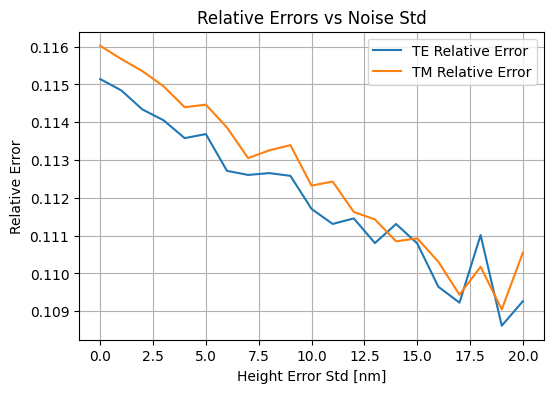

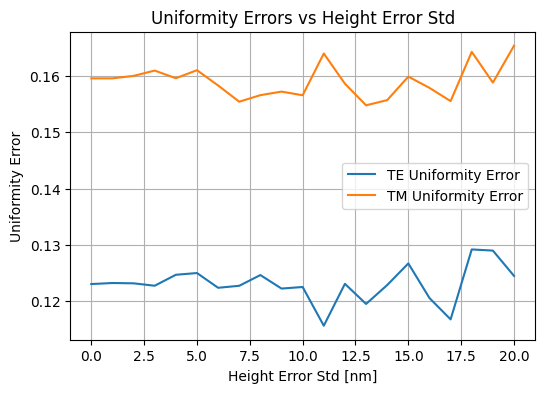

In [45]:
import matplotlib.pyplot as plt

# Plot relative errors
plt.figure(figsize=(6, 4))
plt.plot(1000*stds.cpu(), te_relative_errors, label='TE Relative Error')
plt.plot(1000*stds.cpu(), tm_relative_errors, label='TM Relative Error')
plt.xlabel('Height Error Std [nm]')
plt.ylabel('Relative Error')
plt.title('Relative Errors vs Noise Std')
plt.legend()
plt.grid(True)
plt.savefig(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'relative_errors_vs_height_error_std.pdf'), dpi=600)
plt.show()
plt.close('all')

# Plot uniformity errors
plt.figure(figsize=(6, 4))
plt.plot(1000*stds.cpu(), te_ue_errors, label='TE Uniformity Error')
plt.plot(1000*stds.cpu(), tm_ue_errors, label='TM Uniformity Error')
plt.xlabel('Height Error Std [nm]')
plt.ylabel('Uniformity Error')
plt.title('Uniformity Errors vs Height Error Std')
plt.legend()
plt.grid(True)
plt.savefig(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'uniformity_errors_vs_height_error_std.pdf'), dpi=600)
plt.show()
plt.close('all')

# Features Placement Error Test

In [3]:
import torch
import torch.nn.functional as F

# -- helpers (same idea as before) --
def _gaussian_1d(sigma: float, device, dtype):
    k = max(3, int(6 * sigma + 1) | 1)  # odd, >=3
    x = torch.arange(k, device=device, dtype=dtype) - (k // 2)
    g = torch.exp(-0.5 * (x / sigma) ** 2)
    g = g / g.sum()
    return g.view(1, 1, 1, k)

def _sep_gaussian_blur(x, sigma):
    if sigma <= 0:
        return x
    gW = _gaussian_1d(sigma, x.device, x.dtype)
    gH = gW.transpose(2, 3)
    padW = (gW.shape[-1] // 2, gW.shape[-1] // 2, 0, 0)
    padH = (0, 0, gH.shape[-2] // 2, gH.shape[-2] // 2)
    x = F.conv2d(F.pad(x, padW, mode="circular"), gW)
    x = F.conv2d(F.pad(x, padH, mode="circular"), gH)
    return x

def _morph_sum(x, r):
    k = 2 * r + 1
    kernel = torch.ones((1, 1, k, k), device=x.device, dtype=x.dtype)
    return F.conv2d(F.pad(x, (r, r, r, r), mode="circular"), kernel, padding=0)

@torch.no_grad()
def morph_shift_nonuniform_smooth(
    x,
    r_dilate=1,
    r_erode=1,
    p_expand=0.5,         # average fraction that prefers dilation
    region_sigma=8.0,     # size of expand/shrink regions (lower freq if larger)
    temperature=1.5,      # softens the expand/shrink transition (↑ = smoother)
    blend_sigma=0.0,      # optional feathering before final threshold
    preserve_area=False,  # keep approx same number of foreground pixels
    seed=None,
):
    """
    Non-uniform morphological shift with *smooth* transitions and circular padding.

    Args:
        x: [B,1,H,W] binary {0,1}
        temperature:   softness of transition (sigmoid slope). Larger -> smoother.
        blend_sigma:   Gaussian blur on blended map before thresholding.
        preserve_area: if True, thresholds each sample to keep its original # of ones.

    Returns:
        y:     [B,1,H,W] binary {0,1}
        mask:  [B,1,H,W] float in [0,1], soft dilation preference (1=dilate, 0=erode)
    """
    assert x.dim() == 4 and x.size(1) == 1
    B, _, H, W = x.shape
    dtype = torch.float32
    xi = x.to(dtype)

    # (1) Uniform dilation / erosion results
    s_d = _morph_sum(xi, r_dilate)
    y_dil = (s_d > 0).to(dtype)

    k_e = (2 * r_erode + 1) ** 2
    s_e = _morph_sum(xi, r_erode)
    y_ero = (s_e == k_e).to(dtype)

    # (2) Smooth preference field -> soft mask m in [0,1]
    if seed is not None:
        torch.manual_seed(seed)
        if x.is_cuda:
            torch.cuda.manual_seed_all(seed)

    noise = torch.randn((B, 1, H, W), device=x.device, dtype=dtype)
    field = _sep_gaussian_blur(noise, region_sigma)

    # Center field so that mean(m) ~ p_expand
    # We pick a threshold t per sample such that fraction above t equals p_expand,
    # then turn field into a soft mask via sigmoid around that per-sample t.
    p_expand = float(max(0.0, min(1.0, p_expand)))
    flat = field.reshape(B, -1)
    t = torch.quantile(flat, q=1.0 - p_expand, dim=1, keepdim=True).view(B, 1, 1, 1)

    # Soft transition: m ≈ sigmoid((field - t)/temperature)
    # ↑ temperature makes the boundary between expand/shrink more gradual.
    m = torch.sigmoid((field - t) / max(1e-6, float(temperature)))

    # (3) Blend and feather, then threshold to binary
    z = m * y_dil + (1.0 - m) * y_ero  # still in [0,1]
    if blend_sigma > 0:
        z = _sep_gaussian_blur(z, blend_sigma)

    if preserve_area:
        # keep number of foreground pixels ~ original
        k = (xi.view(B, -1).sum(dim=1)).clamp(min=0, max=H * W)  # per-sample target count
        z_flat = z.view(B, -1)
        # choose per-sample threshold so that ~k pixels are 1
        # (if multiple equal values, result is approximate)
        thresh = torch.quantile(z_flat, q=1.0 - (k / (H * W + 1e-6)), dim=1, keepdim=True).view(B, 1, 1, 1)
        y = (z >= thresh).to(dtype)
    else:
        y = (z >= 0.5).to(dtype)

    return y, m  # return soft mask for inspection


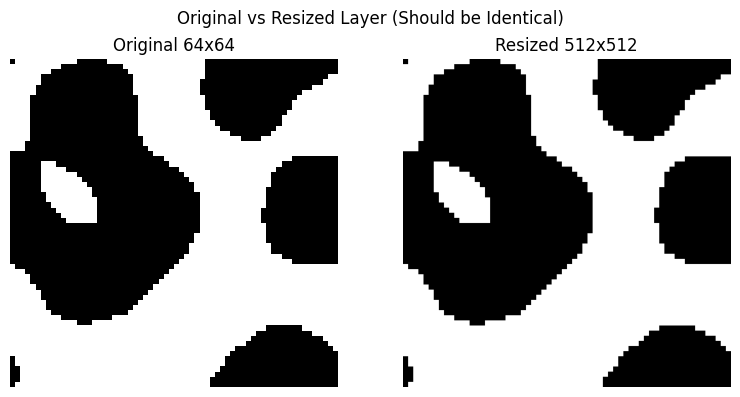

In [4]:
# Resize from 64x64 to 512x512 -> each pixel now represents 9nm rather than 71.875nm 
from torchvision.transforms import InterpolationMode, Resize

layer_small = layer.clone()
_upsample = Resize((512, 512), interpolation=InterpolationMode.NEAREST_EXACT)
upsample = lambda x: _upsample(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
_downsample = Resize((64, 64), interpolation=InterpolationMode.NEAREST_EXACT)
downsample = lambda x: _downsample(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

layer = upsample(layer_small)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(layer_small.cpu().numpy(), cmap='gray')
axs[0].set_title(f'Original {layer_small.shape[0]}x{layer_small.shape[1]}')
axs[0].axis('off')
axs[1].imshow(layer.cpu().numpy(), cmap='gray')
axs[1].set_title(f'Resized {layer.shape[0]}x{layer.shape[1]}')
axs[1].axis('off')
plt.suptitle('Original vs Resized Layer (Should be Identical)')
plt.tight_layout()
plt.show()

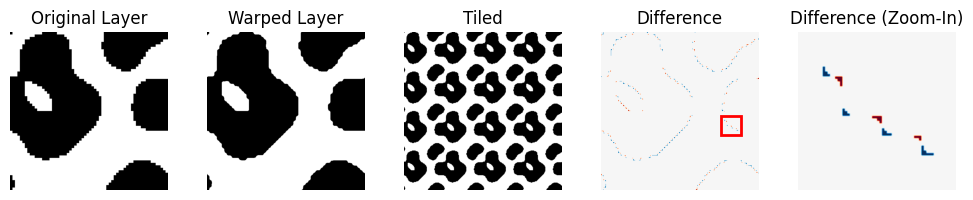

In [5]:
import matplotlib.patches as patches

layer_warped, soft_mask = morph_shift_nonuniform_smooth(
    layer.unsqueeze(0).unsqueeze(0),
    r_dilate=2,
    r_erode=2,
    p_expand=0.7,
    region_sigma=10.0,   # sets region size (localization / frequency)
    temperature=0.1,     # ↑ for smoother transition between expand/shrink
    blend_sigma=3,     # small feather before threshold (optional)
    preserve_area=False, # or True if you want to keep #ones
    seed=0
)

orig = layer.float()
warped = layer_warped.squeeze(0).squeeze(0)
diff = warped - orig

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
axs[0].imshow(orig.cpu().numpy(), cmap='gray')
axs[0].set_title('Original Layer'); axs[0].axis('off')

axs[1].imshow(warped.cpu().numpy(), cmap='gray')
axs[1].set_title('Warped Layer'); axs[1].axis('off')

axs[2].imshow(warped.tile(4,4).cpu().numpy(), cmap='gray')
axs[2].set_title('Tiled'); axs[2].axis('off')

y, x = 270, 390
H = W = 64
rect = patches.Rectangle((x, y), W, H, 
                         linewidth=2, edgecolor='r', facecolor='none')
axs[3].imshow(diff.cpu().numpy(), cmap='RdBu')
axs[3].set_title('Difference'); axs[3].axis('off')
axs[3].add_patch(rect)

axs[4].imshow(diff[y:y+H, x:x+W].cpu().numpy(), cmap='RdBu')
axs[4].set_title('Difference (Zoom-In)'); axs[4].axis('off')

plt.tight_layout(); 
plt.savefig(join(PROJECT_DIR, 'ablations', 'fabrication_errors', 'fabrocation_errors_sensitivity.pdf'), dpi=600)
plt.show()

phy_kwargs: {'periodicity': 4.6, 'h': tensor(0.2759, device='cuda:0'), 'lam': tensor(1.5000, device='cuda:0'), 'tet': 0.0, 'substrate': 'Si', 'structure': 'Si'}


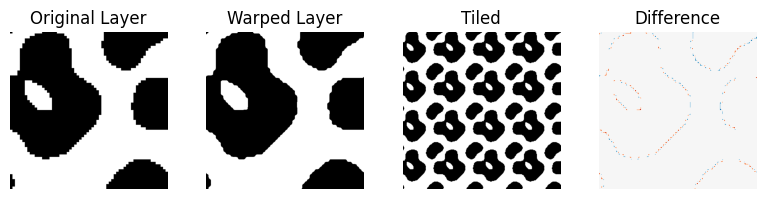

TE Relative Error Mean: 0.11489058509469033
TM Relative Error Mean: 0.11577618171771367
TE Uniformity Error Mean: 0.12802200069030126
TM Uniformity Error Mean: 0.16369085858265559


In [9]:
phy_kwargs = dict(periodicity=data_cfg.periodicity, h=h, lam=lam, tet=0.0, substrate=data_cfg.substrate, structure=data_cfg.structure)
# scatterings = torcwa_simulation(phy_kwargs, warped, project=False, rcwa_orders=data_cfg.rcwa_orders)

print(f'phy_kwargs: {phy_kwargs}')

te_relative_errors = []
tm_relative_errors = []
te_ue_errors = []
tm_ue_errors = []

worst_idx = 0

for seed in range(30):
    warped, _ = morph_shift_nonuniform_smooth(
        layer.unsqueeze(0).unsqueeze(0),
        r_dilate=2,
        r_erode=2,
        p_expand=0.5,
        region_sigma=10.0,   # sets region size (localization / frequency)
        temperature=0.1,     # ↑ for smoother transition between expand/shrink
        blend_sigma=3,     # small feather before threshold (optional)
        preserve_area=False, # or True if you want to keep #ones
        seed=seed
    )
    warped = warped.squeeze(0).squeeze(0)
    scatterings = torcwa_simulation(phy_kwargs, warped, project=False, rcwa_orders=data_cfg.rcwa_orders)

    if seed == 19:
        orig = layer.float()
        diff = warped - orig

        fig, axs = plt.subplots(1, 4, figsize=(8, 2))
        axs[0].imshow(orig.cpu().numpy(), cmap='gray')
        axs[0].set_title('Original Layer'); axs[0].axis('off')

        axs[1].imshow(warped.cpu().numpy(), cmap='gray')
        axs[1].set_title('Warped Layer'); axs[1].axis('off')

        axs[2].imshow(warped.tile(4,4).cpu().numpy(), cmap='gray')
        axs[2].set_title('Tiled'); axs[2].axis('off')

        axs[3].imshow(diff.cpu().numpy(), cmap='RdBu')
        axs[3].set_title('Difference'); axs[3].axis('off')

        plt.tight_layout(); plt.show()
        utils.show_meta_atom_and_scatterings(meta_atom=h*warped, s1=scatterings['Tte'], s2=scatterings['Ttm'], type='te-tm', data_cfg=data_cfg,
            savepath=join(PROJECT_DIR, 'ablations', 'fabrication_errors', f'displacement_fabrication_errors_seed_{seed}.pdf'))
        plt.close('all')

    te_relative_errors.append(relative_error(scatterings['Tte'], desired_scatterings['Tte'][0]).item())
    tm_relative_errors.append(relative_error(scatterings['Ttm'], desired_scatterings['Ttm'][0]).item())
    te_ue_errors.append(uniformity_error(scatterings['Tte'], desired_scatterings['Tte'][0]).item())
    tm_ue_errors.append(uniformity_error(scatterings['Ttm'], desired_scatterings['Ttm'][0]).item())

print("TE Relative Error Mean:", np.mean(np.array(te_relative_errors)))
print("TM Relative Error Mean:", np.mean(np.array(tm_relative_errors)))
print("TE Uniformity Error Mean:", np.mean(np.array(te_ue_errors)))
print("TM Uniformity Error Mean:", np.mean(np.array(tm_ue_errors)))
    

In [80]:
print("AVG Uniformity Error Max:", np.argmax((np.array(te_ue_errors)+np.array(tm_ue_errors))/2))


AVG Uniformity Error Max: 19
